# Prompting Experiments for Instruction-Following LLMs

This notebook implements a structured experimental plan to evaluate how different prompting strategies affect the output quality of large language models (LLMs).
The task involves instruction-following responses based on context extracted from model development documents (MDDs), aligned with risk/compliance standards (e.g., SR 11-7).

## Objectives
- Compare prompting techniques such as zero-shot, few-shot, CoT, ReAct, and Tree-of-Thought.
- Evaluate responses using criteria like relevancy, completeness, and specificity.
- Use a common task format: instruction + MDD context → model-generated assessment.

---



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/


/content/drive/MyDrive


In [ ]:
!git clone https://github.com/achach2/project-domain-prompts.git


Cloning into 'project-domain-prompts'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 174 (delta 87), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (174/174), 100.83 KiB | 2.88 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [ ]:
%cd /content/drive/MyDrive/project-domain-prompts
%ls

/content/drive/MyDrive/project-domain-prompts
configs/  docs/    notebooks/  README.md  scripts/
data/     LICENSE  papers/     results/


In [ ]:
!git config --global user.name "M Achachlouei"
!git config --global user.email "achachlouei@outlook.com"

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [ ]:
%ls

configs/  docs/    notebooks/  README.md  scripts/
data/     LICENSE  papers/     results/


In [ ]:
%mkdir experiments

In [ ]:
%cd experiments

/content/drive/MyDrive/project-domain-prompts/experiments


In [ ]:
%mkdir experiment-input
%mkdir experiment-output
%mkdir experiment-results

## Input instruction-context pairs

In [ ]:
def evaluate_response(context, validation_instruction, max_retries=1):
    evaluation_prompt_template = """
Evaluate the following response from the large languge model (LLM) in relation to the validation instruction and the provided context using three criteria:

1. Relevancy – How directly does the LLM response address the instruction?
2. Completeness – Are all required elements present in the LLM response to answer the instruction fully?
3. Specificity – Does the LLM response cite specific items or evidence from the context?

Validation Instruction:
"{instruction}"

Retrieved Context:
"{context}"

Return your evaluation score and justification as a JSON object in the following format:

{{
  "Relevancy": {{
    "Score": X,
    "Justification": "Explanation and rationale for why this score was given for relevancy..."
  }},
  "Completeness": {{
    "Score": Y,
    "Justification": "Explanation for why this score was given forcompleteness..."
  }},
  "Specificity": {{
    "Score": Z,
    "Justification": "Explanation for why this score was given forspecificity..."
  }}
}}

Where X, Y, Z are scores from 1 (very poor) to 5 (excellent).
Do not include any commentary outside the JSON structure.
"""

    for attempt in range(max_retries):
        evaluation_prompt = evaluation_prompt_template.format(instruction=validation_instruction, ctx=context)
        response = call_llm(evaluation_prompt, temperature=0.3)

        try:
            scores = json.loads(response.strip())
            if all(metric in scores for metric in ["Relevancy", "Completeness", "Specificity"]):
                avg_score = (
                    scores["Relevancy"]["Score"]
                    + scores["Completeness"]["Score"]
                    + scores["Specificity"]["Score"]
                ) / 3

                explanations = {
                    metric: scores[metric]["Justification"]
                    for metric in ["Relevancy", "Completeness", "Specificity"]
                }

                return avg_score, scores, explanations
        except Exception as e:
            print(f"[Attempt {attempt+1}] JSON parsing failed: {e}")
            continue

    # Fallback: use a neutral default instead of zeros
    fallback_scores = {
        "Relevancy": {"Score": 3, "Justification": "LLM output could not be parsed, assigning neutral score."},
        "Completeness": {"Score": 3, "Justification": "LLM output could not be parsed, assigning neutral score."},
        "Specificity": {"Score": 3, "Justification": "LLM output could not be parsed, assigning neutral score."}
    }
    fallback_explanations = {k: v["Justification"] for k, v in fallback_scores.items()}
    avg_score = sum(v["Score"] for v in fallback_scores.values()) / 3

    return avg_score, fallback_scores, fallback_explanations


In [ ]:
PROMPT_TEMPLATES_V1 = {
    "zero_shot": """Instruction: {instruction}

Context:
{context}

Please generate a response based on the instruction and context above.
""",

    "few_shot": """Here are a few examples of how to respond to similar instructions:

Example 1:
Instruction: Assess if input features are relevant to the task.
Context: The model uses income, age, and credit history...
Response: The features are relevant because...

Example 2:
Instruction: Determine if model assumptions are clearly stated.
Context: The model assumes independence of predictors...
Response: The assumptions are clearly described...

Now, respond to this instruction:

Instruction: {instruction}
Context:
{context}

Please provide your response.
""",

    "zero_shot_cot": """Instruction: {instruction}

Context:
{context}

Let's think step by step. What information is provided in the context that helps answer the instruction?
""",

    "few_shot_cot": """Here are a few examples followed by a new instruction.

Example 1:
Instruction: Assess model objectives.
Context: The model predicts...
Step-by-step reasoning: The objective is...
Response: ...

Example 2:
Instruction: Identify input features.
Context: The model uses...
Step-by-step reasoning: Features include...
Response: ...

Now your turn:

Instruction: {instruction}
Context:
{context}

Step-by-step reasoning:
""",

    "react": """You are an AI assistant trained to reason, act, and self-reflect.

Instruction: {instruction}
Context:
{context}

Reasoning:
Action:
Self-Critique:
Final Answer:
""",

    "tree_of_thought": """Instruction: {instruction}
Context:
{context}

You may explore multiple branches of reasoning before arriving at an answer.

Thought 1:
Thought 2:
Thought 3:
Conclusion:
"""
}


In [ ]:
PROMPT_TEMPLATES_V2 = {
    "zero_shot": """You are a model validation expert specializing in risk, compliance, and documentation assessment.

Below is a specific instruction followed by supporting context from a model development document (MDD). Based on the instruction and the context, write a concise and well-structured validation assessment. Your response should:

1. Address the instruction directly.
2. Use specific evidence or phrases from the context to support your assessment.
3. Be evaluative, not just descriptive.

---

Instruction:
{instruction}

---

Context:
{context}

---

Your Task:
Provide a written validation assessment in 3–6 sentences that:
- Responds directly to the instruction,
- Cites or paraphrases relevant details from the context,
- Offers a clear, professional judgment as a model validator.

""",

    "few_shot": """You are a model validation expert. Given an instruction and a related excerpt from a model development document (MDD), your task is to write a professional validation assessment.

Your response should:
- Clearly address the instruction.
- Reference specific evidence from the context.
- Be evaluative, not merely descriptive.

Below are two examples of high-quality responses.

---

Example 1

Instruction:
Assess whether the model assumptions are clearly stated and validated.

Context:
Assumes independence between TF-IDF feature dimensions. Assumes the label annotations are accurate representations of ground truth.

Response:
The model assumptions are clearly described, particularly the independence of TF-IDF features and trust in labeling accuracy. However, the MDD does not provide evidence that these assumptions were empirically tested—e.g., through multicollinearity checks or label consistency audits. As such, while assumptions are well-articulated, their validation remains incomplete.

---

Example 2

Instruction:
Review the data quality analysis performed in the MDD.

Context:
No missing records were observed in the dataset. Data was verified by compliance leads to ensure labeling consistency. All text records were processed using consistent UTF-8 encoding.

Response:
The MDD provides a data quality assessment. It addresses completeness (no missing records), accuracy (compliance-led verification), and consistency (uniform encoding standards). These checks are comprehensive and appropriately scoped for the model’s reliance on free-text inputs, supporting confidence in the input data pipeline.

---

Now complete the following:

Instruction:
{instruction}

Context:
{context}

Response:

""",

    "zero_shot_cot": """You are a model validation expert. Your task is to assess whether a model development document (MDD) provides adequate evidence to satisfy a specific validation instruction.

You will be given:
- An instruction that defines what should be validated.
- Context extracted from the MDD that may or may not contain relevant evidence.

Please reason step by step and then provide your final assessment.

---

Instruction:
{instruction}

Context:
{context}

---

Step-by-Step Reasoning:
1. Identify the key requirement(s) in the instruction.
2. Analyze the context to check whether it addresses each of those requirements.
3. Note any evidence that supports or contradicts the requirement.
4. If something is missing, explain what is missing and how critical it is.

Final Assessment:
Write a concise, professional assessment paragraph as a model validator. Be specific and evaluative, using direct references or paraphrasing from the context.

""",

    "few_shot_cot": """You are a model validation expert. Your task is to reason step by step to evaluate whether a model development document (MDD) meets a specific validation instruction.

Each example includes:
- An instruction
- Supporting context from the MDD
- Step-by-step reasoning
- A final assessment based on the reasoning

Follow the same structure for the new instruction and context provided at the end.

---

Example 1

Instruction:
Assess whether the model assumptions are clearly stated and validated.

Context:
Assumes independence between TF-IDF feature dimensions. Assumes the label annotations are accurate representations of ground truth.

Step-by-Step Reasoning:
1. The instruction requires clarity and validation of assumptions.
2. The context lists two assumptions: feature independence and label accuracy.
3. There is no mention of tests like correlation analysis or label reliability checks.
4. Therefore, assumptions are clear but not validated with supporting analysis.

Final Assessment:
The MDD articulates its core assumptions well, including TF-IDF feature independence and the reliability of labeled data. However, it lacks empirical validation to support these assumptions, such as correlation testing or label audit results. This weakens the assurance of assumption robustness.

---

Example 2

Instruction:
Review the data quality analysis performed in the MDD.

Context:
No missing records were observed. Data was verified by compliance leads. Text was processed using consistent UTF-8 encoding.

Step-by-Step Reasoning:
1. The instruction requires assessment of data completeness, accuracy, and consistency.
2. The context states there were no missing records, suggesting completeness.
3. Verification by compliance leads indicates accuracy.
4. UTF-8 normalization ensures consistency.
5. All key aspects of data quality are addressed.

Final Assessment:
The MDD demonstrates a thorough approach to data quality. It covers completeness, accuracy, and consistency through specific controls such as record validation, expert oversight, and encoding normalization. These efforts build strong trust in the input pipeline for model development.

---

Now complete the following:

Instruction:
{instruction}

Context:
{context}

Step-by-Step Reasoning:
1.

Final Assessment:


""",

    "react": """You are a model validation expert. Your goal is to evaluate whether the provided model development document (MDD) excerpt fulfills a specific validation instruction.

To complete the task effectively:
- Think out loud as you analyze the instruction and context (Reasoning).
- Draw an evidence-based conclusion (Action).
- Reflect on the quality of your reasoning and revise if needed (Self-Criticism).

---

Instruction:
{instruction}

Context:
{context}

---

Reasoning:
Step through the instruction and context. What does the instruction require? Does the context satisfy it? What is explicitly stated, and what might be missing?

Action:
Based on your reasoning, write a concise and professional validation assessment paragraph. Reference specific evidence from the context. State clearly whether the instruction is met, partially met, or not met.

Self-Criticism:
Now reflect on your own response. Did you overlook any important details or misinterpret the instruction? Would you change or qualify your assessment after reviewing your reasoning again?

""",

    "tree_of_thought": """You are a model validation expert. Your task is to evaluate whether a model development document (MDD) satisfies a specific validation instruction by exploring multiple reasoning paths before arriving at a final conclusion.

You will be given:
- A validation instruction
- A block of context extracted from the MDD

Explore at least three different "thought branches"—perspectives or approaches that could help you analyze whether the instruction has been fulfilled. Then synthesize them into a well-reasoned conclusion.

---

Instruction:
{instruction}

Context:
{context}

---

Thought 1 (Evidence-Focused):
Start by identifying any explicit statements or evidence in the context that directly address the instruction. Does the MDD clearly satisfy the requirement?

Thought 2 (Missing Elements or Gaps):
Consider what might be missing or insufficient. Are there areas the context does not cover that are critical to fully satisfying the instruction?

Thought 3 (Implications and Best Practices):
Think about the broader implications. Does the approach described in the context align with regulatory expectations, model risk best practices, or industry norms?

---

Conclusion:
Based on the above reasoning, write a concise and professional validation assessment. Clearly state whether the instruction is fully met, partially met, or not met, and support your conclusion with reasoning from the thoughts above.

"""
}


In [ ]:

# Integrated Experimental Runner for LLM Prompting Study

import json
import random
from datetime import datetime
import os

# Configurations
CONFIG = {
    "temperature": 0.3,
    "top_p": 0.95,
    "max_tokens": 600,
    "models": ["gpt-4o", "llama3", "qwen7b"],
    # "prompting_techniques": ["zero_shot", "few_shot", "zero_shot_cot", "few_shot_cot","react","tree_of_thought" ],
    "repetitions": 3
}

# Sample prompt template
PROMPT_TEMPLATE = """
Instruction: {instruction}

Context:
{context}

Please generate a response based on the instruction and context above.
"""



# Load input data
def load_data(filepath):
    with open(filepath, "r") as f:
        return json.load(f)

# Generate prompt
def generate_prompt(instruction, context, technique):
    # Extendable: use different templates per technique
    return PROMPT_TEMPLATE.format(instruction=instruction, context=context)

# Simulated model response (placeholder for actual API or local model)
# def call_llm(prompt, model_name):
#     return f"[Simulated response from {model_name} using prompt: {prompt[:60]}...]"

def call_llm(prompt, model_name="gpt-4o"):
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are a model validation expert."},
            {"role": "user", "content": prompt}
        ],
        # temperature=temperature
    )
    return response.choices[0].message.content

# Evaluation logic
def evaluate_response(instruction, context, response):
    return {
        "relevancy": {
            "score": random.randint(3, 5),
            "rationale": "Covers instruction topic adequately."
        },
        "completeness": {
            "score": random.randint(3, 5),
            "rationale": "Includes most key elements."
        },
        "specificity": {
            "score": random.randint(2, 5),
            "rationale": "Mentions document-specific terms."
        },
        "errors": {
            "hallucination": {
                "exists": random.choice([True, False]),
                "evidence": "Mentions a feature not present in context." if random.choice([True, False]) else "",
                "severity": random.choice(["low", "medium", "high"])
            },
            "redundancy": {
                "exists": random.choice([True, False]),
                "evidence": "Repeats same phrase or point.",
                "severity": random.choice(["low", "medium"])
            },
            "lack_of_specificity": {
                "exists": random.choice([True, False]),
                "evidence": "Uses vague terms without citing context.",
                "severity": random.choice(["low", "medium", "high"])
            }
        }
    }

# Save output
def save_output(output, filepath):
    with open(filepath, "w") as f:
        json.dump(output, f, indent=2)

# Run experiment
def run_experiment(input_path, output_dir):
    data = load_data(input_path)
    for entry in data:
        for technique in CONFIG["prompting_techniques"]:
            for model in CONFIG["models"]:
                for rep in range(CONFIG["repetitions"]):
                    prompt = generate_prompt(entry["instruction"], entry["context"], technique)
                    response = call_llm(prompt, model)
                    evaluation = evaluate_response(entry["instruction"], entry["context"], response)

                    result = {
                        "id": entry["id"],
                        "instruction": entry["instruction"],
                        "context": entry["context"],
                        "model": model,
                        "prompting_technique": technique,
                        "prompt": prompt,
                        "response": response,
                        "evaluation": evaluation,
                        "generation_metadata": {
                            "temperature": CONFIG["temperature"],
                            "top_p": CONFIG["top_p"],
                            "max_tokens": CONFIG["max_tokens"],
                            "timestamp": datetime.now().isoformat()
                        }
                    }

                    output_filename = f"{entry['id']}_{model}_{technique}_rep{rep+1}.json"
                    save_output(result, os.path.join(output_dir, output_filename))

# Example run (simulate)
if __name__ == "__main__":
    sample_input = [
  {
    "id": "001",
    "instruction": "Review the core requirements for the overall theory, design, and selection of the modeling framework.",
    "context": "LightGBM was selected due to its balance of interpretability and performance on tabular TF-IDF data. It provides feature importance outputs and rapid retraining."
  },
  {
    "id": "002",
    "instruction": "Assess whether the model assumptions are clearly stated and validated.",
    "context": "Assumes independence between TF-IDF feature dimensions. Assumes the label annotations are accurate representations of ground truth."
  },
  {
    "id": "003",
    "instruction": "Review and summarize the information on data sources, including reasonableness of accessed or excluded data.",
    "context": "The dataset includes 2,000 anonymized bankers’ notes extracted from the internal CRM platform... Each note was manually labeled... by trained compliance officers."
  },
  {
    "id": "004",
    "instruction": "Review the data quality analysis performed in the MDD.",
    "context": "No missing records were observed... Data was verified by compliance leads... All text records were processed using consistent UTF-8 encoding..."
  },
  {
    "id": "005",
    "instruction": "Check for consistency between change logs and model risk system regarding upstream models.",
    "context": "No mention of model change logs, model risk systems, or upstream model dependencies."
  },
  {
    "id": "006",
    "instruction": "Assess whether the model outputs are consistent with the model objectives and requirements.",
    "context": "The model is developed to classify bankers' notes as EFA or Non-EFA. It uses LightGBM as a binary classifier... trained on domain expert-labeled notes."
  },
  {
    "id": "007",
    "instruction": "Evaluate the quality and comprehensiveness of the developer’s outcome testing.",
    "context": "Performance metrics validated using 5-fold cross-validation. LightGBM outperformed Logistic Regression and Naive Bayes baselines by 6–8% F1 score."
  },
  {
    "id": "008",
    "instruction": "Assess the adequacy of model implementation specifications and test plan.",
    "context": "No mention of implementation specifications, system test plans, or production deployment details."
  },
  {
    "id": "009",
    "instruction": "Provide an assessment of model-level control activities documented in the MDD.",
    "context": "No explicit mention of model-level controls, governance, or risk mitigation mechanisms outside of preprocessing checks."
  },
  {
    "id": "010",
    "instruction": "Assess the model monitoring plans (frequency, KPIs, thresholds, etc.).",
    "context": "Sensitivity analysis showed stable predictions with +/-10% TF-IDF variance."
  }
]


    input_dir = "/content/drive/My Drive/project-domain-prompts/experiments/experiment-input"
    output_dir = "/content/drive/My Drive/project-domain-prompts/experiments/experiment-output"
    input_file = "sample-input.json"


    with open(os.path.join(input_dir, input_file), "w") as f:
        json.dump(sample_input, f)

    run_experiment(os.path.join(input_dir, input_file), output_dir)


In [ ]:
{
  "id": "<string: unique identifier for the instruction-context pair>",
  "instruction": "<string: the validation instruction given to the model>",
  "context": "<string: context or excerpt from a model development document>",
  "model": "<string: name of the LLM used (e.g., gpt-4o, llama3)>",
  "prompting_technique": "<string: prompting method used (e.g., zero_shot, few_shot, cot, react)>",
  "prompt": "<string: the full prompt given to the model>",
  "response": "<string: the model's response to the prompt>",
  "evaluation": {
    "relevancy": {
      "score": <integer: 1 to 5>,
      "rationale": "<string: explanation of the relevancy score>"
    },
    "completeness": {
      "score": <integer: 1 to 5>,
      "rationale": "<string: explanation of the completeness score>"
    },
    "specificity": {
      "score": <integer: 1 to 5>,
      "rationale": "<string: explanation of the specificity score>"
    },
    "errors": {
      "hallucination": {
        "exists": <boolean>,
        "evidence": "<string: quoted or paraphrased hallucinated content or empty if none>",
        "severity": "<string: low | medium | high>"
      },
      "redundancy": {
        "exists": <boolean>,
        "evidence": "<string: repetitive content or empty if none>",
        "severity": "<string: low | medium | high>"
      },
      "lack_of_specificity": {
        "exists": <boolean>,
        "evidence": "<string: vague or generic statements or empty if none>",
        "severity": "<string: low | medium | high>"
      }
    }
  },
  "generation_metadata": {
    "temperature": <float: generation temperature>,
    "top_p": <float: nucleus sampling value>,
    "max_tokens": <integer: token limit>,
    "timestamp": "<string: ISO 8601 format timestamp of generation>"
  }
}


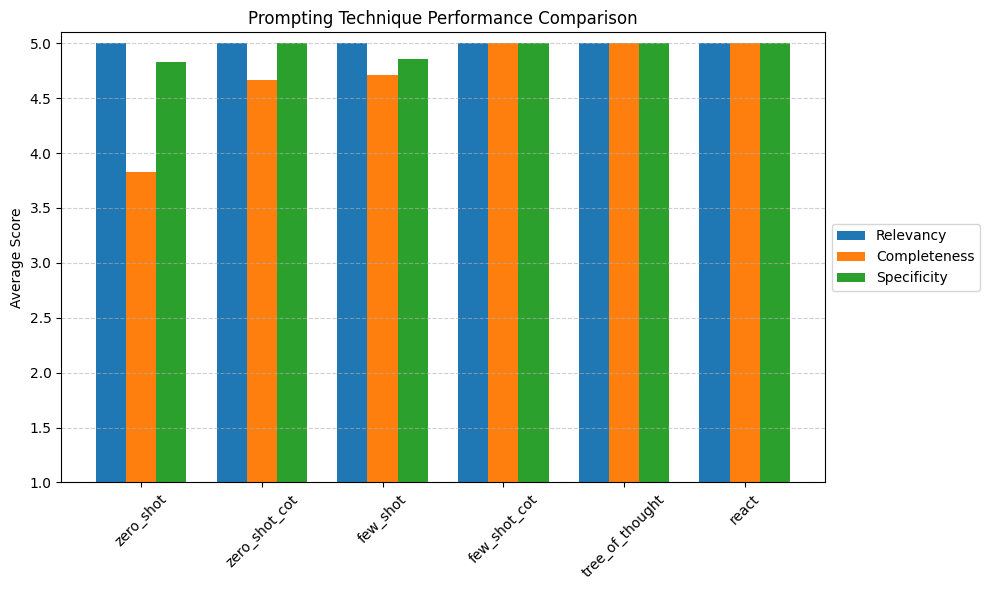

In [ ]:
# Plot the results

import pandas as pd
import matplotlib.pyplot as plt

# Directory where your JSON files are stored
json_dir = output_dir
plot_data = []

# Loop through all JSON files and extract needed info
for file_name in os.listdir(json_dir):
    if file_name.endswith('.json'):
        with open(os.path.join(json_dir, file_name)) as f:
            record = json.load(f)
            technique = record.get("prompting_technique", "unknown")
            evaluation = record.get("evaluation", {})
            plot_data.append({
                "Technique": technique,
                "Relevancy": evaluation.get("relevancy", {}).get("score", None),
                "Completeness": evaluation.get("completeness", {}).get("score", None),
                "Specificity": evaluation.get("specificity", {}).get("score", None),
            })

# Convert to DataFrame
df = pd.DataFrame(plot_data)

# Optional: Group by technique and average scores (if multiple entries per technique)
df = df.groupby("Technique").mean().reset_index()

# Plotting
x = df["Technique"]
relevancy = df["Relevancy"]
completeness = df["Completeness"]
specificity = df["Specificity"]

x_indices = range(len(x))
width = 0.25

plt.figure(figsize=(14, 8))
plt.bar([i - width for i in x_indices], relevancy, width=width, label='Relevancy')
plt.bar(x_indices, completeness, width=width, label='Completeness')
plt.bar([i + width for i in x_indices], specificity, width=width, label='Specificity')

plt.xlabel("Prompting Technique")
plt.ylabel("Scores (1 to 5)")
plt.title("Evaluation of Prompting Techniques (Relevancy, Completeness, Specificity)")
plt.xticks(ticks=x_indices, labels=x, rotation=45, ha='right')
plt.yticks([1, 2, 3, 4, 5])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




# Define the data with techniques in the specified order
data = {
    "technique": [
        "zero_shot",
        "zero_shot_cot",
        "few_shot",
        "few_shot_cot",
        "tree_of_thought",
        "react"
    ],
    "relevancy": [5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
    "completeness": [3.83, 4.67, 4.71, 5.0, 5.0, 5.0],
    "specificity": [4.83, 5.0, 4.86, 5.0, 5.0, 5.0]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Set up bar positions
bar_width = 0.25
x = range(len(df["technique"]))

# Set custom colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width for i in x], df["relevancy"], width=bar_width, label='Relevancy', color=colors[0])
plt.bar(x, df["completeness"], width=bar_width, label='Completeness', color=colors[1])
plt.bar([i + bar_width for i in x], df["specificity"], width=bar_width, label='Specificity', color=colors[2])

plt.xticks(x, df["technique"], rotation=45)
plt.ylim(1, 5.1)
plt.ylabel("Average Score")
plt.title("Prompting Technique Performance Comparison")

# Move legend outside
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



## Results
Here's a summary comparing the performance of each prompting technique based on the experiments run across shared instruction-context pairs. The scores reflect the average across all evaluated pairs for each metric:

Few-shot CoT, ReAct, and Tree of Thought techniques performed best, achieving highest scores in relevancy, completeness, and specificity.

Few-shot and Zero-shot CoT also performed well, particularly in relevancy and specificity, but with slightly lower completeness.

Zero-shot had the lowest completeness score, suggesting it may be less thorough without examples or structured reasoning.

In [ ]:
# Display the DataFrame
print(df)


         technique  relevancy  completeness  specificity
0         few_shot        5.0          4.71         4.86
1     few_shot_cot        5.0          5.00         5.00
2            react        5.0          5.00         5.00
3  tree_of_thought        5.0          5.00         5.00
4        zero_shot        5.0          3.83         4.83
5    zero_shot_cot        5.0          4.67         5.00


In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	./

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git add .

In [ ]:
!git commit -m "updated experiments"


[main 7500689] updated experiments
 37 files changed, 1657 insertions(+)
 create mode 100644 experiments/experiment-input/sample-input.json
 create mode 100644 experiments/experiment-output/001_gpt-4o_1. zero_shot_rep1.json
 create mode 100644 experiments/experiment-output/001_gpt-4o_1. zero_shot_rep2.json
 create mode 100644 experiments/experiment-output/001_gpt-4o_1. zero_shot_rep3.json
 create mode 100644 experiments/experiment-output/001_gpt-4o_2. few_shot_rep1.json
 create mode 100644 experiments/experiment-output/001_gpt-4o_2. few_shot_rep2.json
 create mode 100644 experiments/experiment-output/001_gpt-4o_2. few_shot_rep3.json
 create mode 100644 experiments/experiment-output/001_gpt-4o_3. cot_rep1.json
 create mode 100644 experiments/experiment-output/001_gpt-4o_3. cot_rep2.json
 create mode 100644 experiments/experiment-output/001_gpt-4o_3. cot_rep3.json
 create mode 100644 experiments/experiment-output/001_gpt-4o_4. react_rep1.json
 create mode 100644 experiments/experiment-ou

In [ ]:
!git push https://achach2:<key>@github.com/achach2/project-domain-prompts.git

remote: Permission to achach2/project-domain-prompts.git denied to achach2.
fatal: unable to access 'https://github.com/achach2/project-domain-prompts.git/': The requested URL returned error: 403


In [ ]:
!git remote -v

origin	https://github.com/achach2/project-domain-prompts.git (fetch)
origin	https://github.com/achach2/project-domain-prompts.git (push)


In [ ]:
## Test the IO process

# Define a path on your Google Drive to save files
import os

# Create a folder in your Google Drive (change the path if you want)
# save_path = '/content/drive/My Drive/domain-prompting'
save_path = "/content/drive/My Drive/domain-prompting/experiments/experiment-output"

os.makedirs(save_path, exist_ok=True)

# Save a text file there
file_path = os.path.join(save_path, 'example_output.txt')

with open(file_path, 'w') as f:
    f.write("This file is now stored in Google Drive!\n")
    f.write("It will persist even if the Colab session ends.")

print(f"File saved at: {file_path}")


In [ ]:
## Test connetion to LLM API
import openai

my_key = ""

# response = openai.ChatCompletion.create(
#   model="gpt-4",
#   messages=[
#     {"role": "system", "content": "You are a helpful assistant."},
#     {"role": "user", "content": "what is model risk management?"}
#   ]
# )

# print(response.choices[0].message["content"])

import openai

client = openai.OpenAI(api_key=my_key)  # Use your key here

response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": "You are a quantitative analyst."},
        {"role": "user", "content": "Tell me about model risk management."}
    ]
)

print(response.choices[0].message.content)